## Model Train LSTM- Tesis Javier-Uriel

### Importamos algunas librerías que nos serán útiles más adelante

In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

import tensorflow as tf
from tensorflow.keras import models, layers
#assert (tf.__version__=='2.4.1'), 'Versión incorrecta de Tensorflow, por favor instale 2.4.1'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output

pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import gc #garbage collector
import gc; gc.enable()

import multiprocessing
THREADS = multiprocessing.cpu_count()
print(tf.__version__)

2.1.0


In [2]:
"""gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)"""

'gpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n  try:\n    # Currently, memory growth needs to be the same across GPUs\n    for gpu in gpus:\n      tf.config.experimental.set_memory_growth(gpu, True)\n    logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Memory growth must be set before GPUs have been initialized\n    print(e)'

### Leemos el Dataset

In [3]:
#Dataset solo movimientos en Z
rpm_list = ['Motor1','Motor2','Motor3','Motor4']
states_list_org = ['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P',
       'Q', 'R', 'X_r', 'Y_r', 'Z_r','Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r',
       'Dy_r', 'Dz_r','Ac_Dx', 'Ac_Dy','Ac_Dz','Gyro P', 'Gyro Q', 'Gyro R','Sonar Altitud',
       'Pressure Altitud', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z']
directory = "./Datasets/DatasetXYZYaw_2022V2"
ORDER = 3
states_list=states_list_org.copy()

In [4]:
path = directory
if not os.path.exists(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)
else:
    print(f"{path} already exist")

./Datasets/DatasetXYZYaw_2022V2 already exist


In [5]:
def pandas_read():
    dfs = []
    global states_list
    # reading train data
    for filename in os.listdir(directory):
        #Si el archivo no termina en .csv continua vuelve al inicio del bucle for
        #if not filename.endswith(".csv"):
        #    continue
        a = []
        df = pd.read_csv(os.path.join(directory, filename))
        delete_list =['Bat_V','Bat_Percentage','Flag_Pitch_Roll','P_r',
                      'Q_r', 'R_r','Acceleracion P', 'Acceleracion Q', 'Acceleracion R']
        rpm_list = ['Motor1','Motor2','Motor3','Motor4']
        Aux = df.drop(rpm_list+delete_list, axis=1)
        origin_columns2 = Aux.drop('Time',axis=1).columns
        origin_columns = Aux.columns
        if df['X'].max()>126:
            print(filename)
        # desplazar solo las columnas con estados
        for o in range(ORDER):
            delay_columns = origin_columns + '_' + str(o+1)
            a.append(delay_columns)
            Aux[delay_columns]=df.drop(rpm_list+delete_list, axis=1).shift(periods=o+1, fill_value=0)
        # Quitar las 3 primeras filas
        #Aux[rpm_list] = df[rpm_list].drop([0,1,2],axis=0)
        #Aux=Aux.drop([0,1,2],axis=0)
        Aux[rpm_list] = df[rpm_list]
        #print(Aux.columns)
        dfs.append(Aux)

    return pd.concat(dfs, axis=0), origin_columns2

In [6]:
#Verifica la existencias del archivo .csv con todos los datos
if not os.path.isfile("/train"+".csv"):
    dataset, origin_columns = pandas_read()
    dataset=dataset.reset_index()
    Time=dataset['Time']
    dataset=dataset.drop(['index','Time','Time_1','Time_2','Time_3'], axis=1)
else:
    for column in states_list_org:
        for n in range(1,ORDER+1):
            states_list.append(column+str(n))

In [7]:
states_list=dataset.drop(rpm_list,axis=1).columns
states_list

Index(['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P',
       ...
       'Ac_Dy_3', 'Ac_Dz_3', 'Gyro P_3', 'Gyro Q_3', 'Gyro R_3',
       'Sonar Altitud_3', 'Pressure Altitud_3', 'Acceleracion X_3',
       'Acceleracion Y_3', 'Acceleracion Z_3'],
      dtype='object', length=128)

In [8]:
descript_list=list(origin_columns)+list(rpm_list)
dt_description=dataset[descript_list].describe()
dt_description.to_csv('data_description_V1.csv', index=False)
dt_description

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Acceleracion X,Acceleracion Y,Acceleracion Z,Motor1,Motor2,Motor3,Motor4
count,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06
mean,-2.148062e+00,8.581393e-01,-1.361919e+00,6.941571e-02,4.212177e-03,-1.258425e-03,-6.380254e-02,4.722424e-02,-4.483362e-04,4.304693e-05,4.907894e-04,8.615122e-04,-4.423323e-01,8.020333e-02,-1.339738e+00,6.943904e-02,5.413407e-04,5.413407e-04,-4.827215e-03,-3.041949e-04,-1.147789e-02,8.251295e-02,-9.250000e-02,-9.432192e+00,-9.457014e-03,-7.006050e-03,2.361579e-03,1.363565e+00,1.012546e+05,-1.705777e-03,2.004448e-03,-4.806519e-05,2.375205e+02,-2.369294e+02,2.371031e+02,-2.376529e+02
std,1.245948e+01,1.280665e+01,3.523353e-01,1.449267e+00,9.329679e-02,1.070563e-01,5.772355e-01,5.947505e-01,4.883165e-01,4.344218e-01,1.903108e-01,3.530311e-01,1.839267e+00,2.001953e+00,3.267278e-01,1.455933e+00,9.463459e-03,9.463459e-03,2.486848e+00,2.673742e+00,3.156394e+00,7.612763e-01,6.163461e-01,1.579708e+00,4.338179e-01,1.915364e-01,3.530295e-01,3.461489e-01,4.206265e+00,1.823827e+00,1.937495e+00,1.819518e+00,6.179896e+01,6.200034e+01,6.209949e+01,6.201273e+01
min,-1.910231e+02,-5.546263e+01,-3.360997e+00,-5.698977e+00,-1.231822e+00,-1.230343e+00,-9.405467e+00,-8.219940e+00,-4.671090e+00,-8.805186e+00,-6.302951e+00,-5.970769e+00,-5.000000e+00,-4.900000e+00,-2.700000e+00,-5.698900e+00,-3.175523e-01,-3.175523e-01,-1.000000e+03,-9.800000e+02,-3.400000e+02,-8.391441e+00,-6.657550e+00,-2.103205e+01,-8.802447e+00,-6.351042e+00,-5.970004e+00,4.400000e-01,1.012305e+05,-1.250098e+02,-1.253153e+02,-1.144005e+02,1.000000e+01,-5.000000e+02,1.000000e+01,-5.000000e+02
25%,-1.141038e+00,-8.488176e-01,-1.589636e+00,-6.071872e-05,-8.617007e-04,-7.853758e-04,-4.524640e-03,-3.553482e-03,-1.090286e-02,-4.570262e-03,-2.357028e-03,-1.192331e-03,-1.060000e+00,-8.200000e-01,-1.587327e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.018413e-02,-2.299868e-01,-9.662053e+00,-1.406391e-02,-9.872207e-03,8.768478e-05,1.102558e+00,1.012519e+05,-1.699710e-02,-7.660736e-02,-1.433379e-01,2.352098e+02,-2.382692e+02,2.348473e+02,-2.382181e+02
50%,-2.475608e-01,-1.067103e-01,-1.307021e+00,1.298457e-06,9.695101e-05,1.268892e-04,0.000000e+00,0.000000e+00,1.731190e-04,-6.421081e-07,4.002890e-06,-1.370747e-05,-2.400000e-01,-1.000000e-01,-1.300000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011609e-01,-7.054463e-02,-9.410419e+00,-9.500641e-03,-7.495971e-03,1.493407e-03,1.308071e+00,1.012552e+05,-8.493662e-05,2.143905e-04,-3.264192e-03,2.366609e+02,-2.365851e+02,2.364810e+02,-2.365589e+02
75%,3.669192e-01,6.018744e-01,-1.101987e+00,2.255217e-04,1.568906e-03,2.024486e-03,3.024116e-03,4.013675e-03,1.086785e-02,4.579417e-03,2.386491e-03,1.178744e-03,3.900000e-01,6.000000e-01,-1.100000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.752108e-01,8.505552e-02,-9.161054e+00,-4.926948e-03,-5.098140e-03,2.885032e-03,1.589461e+00,1.012577e+05,1.629875e-02,7.984044e-02,1.356349e-01,2.385271e+02,-2.350571e+02,2.380607e+02,-2.350024e+02
max,4.092953e+01,1.973594e+02,7.122186e-05,5.625904e+00,1.215662e+00,1.150908e+00,1.108913e+01,8.267406e+00,4.484425e+00,9.052526e+00,6.135386e+00,6.021672e+00,4.700000e+00,4.900000e+00,0.000000e+00,5.621700e+00,3.396701e-01,3.396701e-01,9.399999e+02,9.800000e+02,1.999644e+02,5.398993e+00,5.235673e+00,1.002493e+00,9.030444e+00,6.167398e+00,6.022593e+00,3.362308e+00

### Estados repetidos

En este caso se eliminan estados repetidos y estados que se encuentren en estado transitorio mientras el dron despega o se estabiliza antes de introducir la señal de control.

In [9]:
"""if not os.path.isfile("/train"+".csv"):
    shape_b4 = dataset.shape
    dataset = dataset.drop_duplicates()
    shape_drop = dataset.shape
    print(f'shape_drop={shape_drop}')
    print(f'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}')"""

'if not os.path.isfile("/train"+".csv"):\n    shape_b4 = dataset.shape\n    dataset = dataset.drop_duplicates()\n    shape_drop = dataset.shape\n    print(f\'shape_drop={shape_drop}\')\n    print(f\'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}\')'

### División del dataset en estados y acciones

In [10]:
if not os.path.isfile("/train"+".csv"):
    actions = dataset[rpm_list]
    actions.describe()

#### Normalización de acciones

In [11]:
def normalize_df(df, properties, subpropieties, actions, type_norm="Z-Score"):
    df_norm = pd.DataFrame()
    dict_k = {}
    
    if actions:
        for prop in properties:
            dict_k[prop] = {}
            dict_k[prop]["mean"] = df[prop].mean()
            dict_k[prop]["max"] = df[prop].max()
            dict_k[prop]["min"] = df[prop].min()
            dict_k[prop]["std"] = df[prop].std()
    else:
        i=0
        for prop in properties:
            dict_k[prop] = {}
            print(prop)
            print(subpropieties[i])
            print("-------")
            dict_k[prop]["mean"] = df[subpropieties[i]].mean()
            dict_k[prop]["max"] = df[subpropieties[i]].max()
            dict_k[prop]["min"] = df[subpropieties[i]].min()
            dict_k[prop]["std"] = df[subpropieties[i]].std()
            i=i+1
            if i==len(subpropieties):
                i=0
        
    for prop in properties:
        if type_norm=="Z-Score":
            df_norm[prop] = (df[prop]-dict_k[prop]["mean"])/dict_k[prop]["std"]
        elif type_norm=="Log":
            df_norm[prop] = np.log10(df[prop])
        elif type_norm=="Linear_mean":
            if dict_k[prop]["max"]!=0 or dict_k[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dict_k[prop]["min"])/(dict_k[prop]["max"]-dict_k[prop]["min"]) 
            else:
                df_norm[prop] = df[prop]
        else: #Lineal mean
            if dict_k[prop]["max"]!=0 or dict_k[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dict_k[prop]["mean"])/(dict_k[prop]["max"]-dict_k[prop]["min"])
    dict_k["Norm_type"]=type_norm
    return df_norm, dict_k

In [12]:
if not os.path.isfile("/train"+".csv"):
    actions, dict_act_norm = normalize_df(actions, rpm_list,states_list_org,True, "Linear_mean")
    print(dict_act_norm)
    dataset = dataset.drop(columns=rpm_list)

{'Motor1': {'mean': 237.52054796056765, 'max': 500.0, 'min': 10.0, 'std': 61.798957171414095}, 'Motor2': {'mean': -236.92944454634576, 'max': -10.0, 'min': -500.0, 'std': 62.000340961568426}, 'Motor3': {'mean': 237.10313777953937, 'max': 500.0, 'min': 10.0, 'std': 62.09949153344824}, 'Motor4': {'mean': -237.6528500710943, 'max': -10.0, 'min': -500.0, 'std': 62.012727078556594}, 'Norm_type': 'Linear_mean'}


In [13]:

actions.describe()

,Motor1,Motor2,Motor3,Motor4
count,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06
mean,4.643276e-01,5.368787e-01,4.634758e-01,5.354023e-01
std,1.261203e-01,1.265313e-01,1.267337e-01,1.265566e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.596119e-01,5.341445e-01,4.588721e-01,5.342488e-01
50%,4.625733e-01,5.375814e-01,4.622061e-01,5.376348e-01
75%,4.663819e-01,5.406998e-01,4.654299e-01,5.408115e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
dataset.describe()

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Ac_Dx_1,Ac_Dy_1,Ac_Dz_1,Gyro P_1,Gyro Q_1,Gyro R_1,Sonar Altitud_1,Pressure Altitud_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Ac_Dx_2,Ac_Dy_2,Ac_Dz_2,Gyro P_2,Gyro Q_2,Gyro R_2,Sonar Altitud_2,Pressure Altitud_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Ac_Dx_3,Ac_Dy_3,Ac_Dz_3,Gyro P_3,Gyro Q_3,Gyro R_3,Sonar Altitud_3,Pressure Altitud_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
count,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06
mean,-2.148062e+00,8.581393e-01,-1.361919e+00,6.941571e-02,4.212177e-03,-1.258425e-03,-6.380254e-02,4.722424e-02,-4.483362e-04,4.304693e-05,4.907894e-04,8.615122e-04,-4.423323e-01,8.020333e-02,-1.339738e+00,6.943904e-02,5.413407e-04,5.413407e-04,-4.827215e-03,-3.041949e-04,-1.147789e-02,8.251295e-02,-9.250000e-02,-9.432192e+00,-9.457014e-03,-7.006050e-03,2.361579e-03,1.363565e+00,1.012546e+05,-1.705777e-03,2.004448e-03,-4.806519e-05,-2.147720e+00,8.578926e-01,-1.361861e+00,6.941383e-02,4.211528e-03,-1.258100e-03,-6.379401e-02,4.721422e-02,-4.480958e-04,4.038826e-05,4.897482e-04,8.612665e-04,-4.423082e-01,8.020485e-02,-1.339680e+00,6.943709e-02,5.412611e-04,5.412611e-04,-4.827215e-03,-3.041949e-04,-1.147789e-02,8.251355e-02,-9.249401e-02,-9.431784e+00,-9.459256e-03,-7.006771e-03,2.361371e-03,1.363507e+00,1.012502e+05,-1.711503e-03,2.003557e-03,-5.170801e-05,-2.147378e+00,8.576460e-01,-1.361804e+00,6.941194e-02,4.210891e-03,-1.257771e-03,-6.378545e-02,4.720420e-02,-4.478373e-04,3.781289e-05,4.886570e-04,8.610132e-04,-4.422840e-01,8.020637e-02,-1.339623e+00,6.943514e-02,5.411815e-04,5.411815e-04,-4.827215e-03,-3.041949e-04,-1.147789e-02,8.250546e-02,-9.249524e-02,-9.431386e+00,-9.461414e-03,-7.007543e-03,2.361013e-03,1.363450e+00,1.012458e+05,-1.718385e-03,2.002945e-03,-6.111376e-05,-2.147037e+00,8.573994e-01,-1.361747e+00

#### Definimos los estados

In [15]:
if not os.path.isfile("/train"+".csv"):
    states = dataset[states_list]
    print(f'columns = {states.columns}')
    print(f'shape = {states.shape}')
    #states.head()

columns = Index(['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P',
       ...
       'Ac_Dy_3', 'Ac_Dz_3', 'Gyro P_3', 'Gyro Q_3', 'Gyro R_3',
       'Sonar Altitud_3', 'Pressure Altitud_3', 'Acceleracion X_3',
       'Acceleracion Y_3', 'Acceleracion Z_3'],
      dtype='object', length=128)
shape = (3859368, 128)


### Se Normalizan los estados

In [16]:
if not os.path.isfile("/train"+".csv"):
    states, dict_sts_norm = normalize_df(states, states.columns,states_list_org,False, "Linear_mean")
    dataset = pd.concat([states, actions], axis=1)
    dataset = dataset.drop(columns=rpm_list)
    dataset = pd.concat([states, actions], axis=1)

X
X
-------
Y
Y
-------
Z
Z
-------
Yaw
Yaw
-------
Roll
Roll
-------
Pitch
Pitch
-------
Dx
Dx
-------
Dy
Dy
-------
Dz
Dz
-------
P
P
-------
Q
Q
-------
R
R
-------
X_r
X_r
-------
Y_r
Y_r
-------
Z_r
Z_r
-------
Yaw_r
Yaw_r
-------
Pitch_r
Pitch_r
-------
Roll_r
Roll_r
-------
Dx_r
Dx_r
-------
Dy_r
Dy_r
-------
Dz_r
Dz_r
-------
Ac_Dx
Ac_Dx
-------
Ac_Dy
Ac_Dy
-------
Ac_Dz
Ac_Dz
-------
Gyro P
Gyro P
-------
Gyro Q
Gyro Q
-------
Gyro R
Gyro R
-------
Sonar Altitud
Sonar Altitud
-------
Pressure Altitud
Pressure Altitud
-------
Acceleracion X
Acceleracion X
-------
Acceleracion Y
Acceleracion Y
-------
Acceleracion Z
Acceleracion Z
-------
X_1
X
-------
Y_1
Y
-------
Z_1
Z
-------
Yaw_1
Yaw
-------
Roll_1
Roll
-------
Pitch_1
Pitch
-------
Dx_1
Dx
-------
Dy_1
Dy
-------
Dz_1
Dz
-------
P_1
P
-------
Q_1
Q
-------
R_1
R
-------
X_r_1
X_r
-------
Y_r_1
Y_r
-------
Z_r_1
Z_r
-------
Yaw_r_1
Yaw_r
-------
Pitch_r_1
Pitch_r
-------
Roll_r_1
Roll_r
-------
Dx_r_1
Dx_r
-------
Dy_r_1
D

In [17]:
dict_sts_norm

{'X': {'mean': -2.1480616181491685,
  'max': 40.9295311,
  'min': -191.02311709999998,
  'std': 12.459482527409945},
 'Y': {'mean': 0.8581393134646709,
  'max': 197.35935969999997,
  'min': -55.46263123,
  'std': 12.806650142343253},
 'Z': {'mean': -1.361918699844119,
  'max': 7.122186070999999e-05,
  'min': -3.360996723,
  'std': 0.3523353213722521},
 'Yaw': {'mean': 0.06941571499533916,
  'max': 5.625904082999999,
  'min': -5.698976517,
  'std': 1.4492668167425795},
 'Roll': {'mean': 0.004212177143251644,
  'max': 1.215662241,
  'min': -1.231821656,
  'std': 0.09329678918696645},
 'Pitch': {'mean': -0.0012584251183057412,
  'max': 1.150907874,
  'min': -1.230343223,
  'std': 0.10705626573705745},
 'Dx': {'mean': -0.06380253615855164,
  'max': 11.0891304,
  'min': -9.405467032999999,
  'std': 0.5772355376465645},
 'Dy': {'mean': 0.04722424212205859,
  'max': 8.26740551,
  'min': -8.219940186,
  'std': 0.5947504704047278},
 'Dz': {'mean': -0.0004483361747179684,
  'max': 4.484425068,
 

In [18]:
states.describe()

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Ac_Dx_1,Ac_Dy_1,Ac_Dz_1,Gyro P_1,Gyro Q_1,Gyro R_1,Sonar Altitud_1,Pressure Altitud_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Ac_Dx_2,Ac_Dy_2,Ac_Dz_2,Gyro P_2,Gyro Q_2,Gyro R_2,Sonar Altitud_2,Pressure Altitud_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Ac_Dx_3,Ac_Dy_3,Ac_Dz_3,Gyro P_3,Gyro Q_3,Gyro R_3,Sonar Altitud_3,Pressure Altitud_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
count,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06
mean,8.142828e-01,2.227685e-01,5.947747e-01,5.093557e-01,5.050223e-01,5.161509e-01,4.558111e-01,5.014248e-01,5.101451e-01,4.930771e-01,5.067753e-01,4.979495e-01,4.698627e-01,5.081840e-01,5.038009e-01,5.095436e-01,4.839970e-01,4.839970e-01,5.154614e-01,4.999998e-01,6.296498e-01,6.144806e-01,5.519992e-01,5.264398e-01,4.930771e-01,5.067753e-01,4.980044e-01,3.160394e-01,6.031159e-01,4.969912e-01,4.997974e-01,4.789438e-01,8.142843e-01,2.227675e-01,5.947917e-01,5.093555e-01,5.050220e-01,5.161510e-01,4.558115e-01,5.014242e-01,5.101452e-01,4.930770e-01,5.067752e-01,4.979495e-01,4.698651e-01,5.081842e-01,5.038221e-01,5.095434e-01,4.839969e-01,4.839969e-01,5.154614e-01,4.999998e-01,6.296498e-01,6.144807e-01,5.519997e-01,5.264583e-01,4.930770e-01,5.067752e-01,4.980044e-01,3.160198e-01,4.925133e-01,4.969912e-01,4.997974e-01,4.789438e-01,8.142858e-01,2.227665e-01,5.948087e-01,5.093553e-01,5.050217e-01,5.161511e-01,4.558119e-01,5.014236e-01,5.101452e-01,4.930768e-01,5.067751e-01,4.979495e-01,4.698676e-01,5.081843e-01,5.038434e-01,5.095433e-01,4.839967e-01,4.839967e-01,5.154614e-01,4.999998e-01,6.296498e-01,6.144801e-01,5.519996e-01,5.264764e-01,4.930768e-01,5.067752e-01,4.980043e-01,3.160001e-01,3.819107e-01,4.969912e-01,4.997974e-01,4.789438e-01,8.142872e-01,2.227656e-01,5.948258e-01,5.093552e-01,5.050215e-01,5.161513e-01,4.558123e-

#### Guardamos el dataset en un nuevo archivo .csv

In [19]:
if not os.path.isfile("train"+".csv"):
    #Saca el 10% para prueba y lo guarda en un archivo .csv
    dataset.sample(frac =.10, random_state = 10).to_csv("test.csv", index=False)
    #Saca 90% para entrenamiento y lo guarda en un archivo .csv
    dataset = dataset.sample(frac =.90, random_state = 10)
    #Saca el 20% para validacion y lo guarda en un archivo .csv
    dataset.sample(frac =.20, random_state = 42).to_csv("validation.csv", index=False)
    #Saca el 80% para entrenamiento y lo guarda en un archivo .csv
    dataset.sample(frac =.80, random_state = 42).to_csv("train.csv", index=False)
    #Borra los data frames para no consumir memoria
    del dataset
    del states, actions

OSError: [Errno 28] No space left on device

### Creamos dataset de Tensorflow a partir de csv
Esto es con el fin de no cargar todo el dataset.

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
class YieldReadCSV:
    def __init__(self, file_path=path, file="/train.csv", skip_rows=1, batch_size=512):
        self.file_path = file_path
        self.file = file
        #numero de filas a saltar al inicio de cada archivo
        self.skip_rows = skip_rows
        
        self.batch_size = batch_size
        
    def read_csv(self):
        labels = []
        samples = []
        batchcount = 0
        with open(self.file, 'r') as csvfile:
            data = csv.reader(csvfile, delimiter=',')
            for index, row in enumerate(data):
                if index < self.skip_rows:
                    continue
                samples.append([float(i) for i in row])
                #salidas
                labels.append(samples[batchcount][len(states_list_org)*(ORDER+1):])
                #entradas
                samples[batchcount]=np.array(samples[batchcount][:len(states_list_org)*(ORDER+1)]).reshape((4,len(states_list_org)))
                batchcount += 1
                #pregunta si la cuenta del batch es mayor que el tamaño de batch definido
                if batchcount >= self.batch_size:
                    #retorna las entradas
                    yield np.array(samples),\
                      np.array(labels)
                    #limpia la lista de entradas y vuelve la cuenta a 0
                    labels = []
                    samples = []
                    batchcount = 0
        

In [ ]:
#Cada cuantos datos de entrenamiento se quiere actualizar los pesos 
#16384
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_VAL = 512

In [ ]:
#Se construye el generador
train_generator = YieldReadCSV(file="train.csv", batch_size = BATCH_SIZE_TRAIN)
#Se genera ciertas muestras con el generador y se define el tipo de datos a la salida, no es necesario definir la forma
dataset_train = tf.data.Dataset.from_generator(train_generator.read_csv,
                                        output_types = (tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))

In [ ]:
val_generator = YieldReadCSV(file="validation.csv",  batch_size = BATCH_SIZE_VAL)
dataset_val = tf.data.Dataset.from_generator(val_generator.read_csv,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))


In [ ]:
test_generator = YieldReadCSV(file="test.csv", batch_size = BATCH_SIZE_VAL)
dataset_test = tf.data.Dataset.from_generator(test_generator.read_csv,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=((None, (ORDER+1), len(states_list_org)), (None,4)))

In [ ]:
for _ in range(5):
    x, y = next(train_generator.read_csv())
    print(f'x.shape={x.shape}, y.shape={y.shape}')
print(x[1,1,:])
print(y[1,:])

## Keras Model

In [ ]:
## Callbacks

In [ ]:
main_metric = 'mean_squared_error'
checkpoint_filepath = 'tmp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor=f'val_{main_metric}', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min',
    options=None)

#### Early Stopping

In [ ]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#### Plotting

In [ ]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

#### Definición del Modelo

In [ ]:
#inputs = tf.keras.Input(shape=(len(states_list),), name='inputs')
#x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(inputs)
#x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(x)
# Build the model
window=ORDER+1
model = models.Sequential()
# I arbitrarily picked the output dimensions as 4
#len(states_list_org)
model.add(layers.LSTM(192, input_shape=(window,int(len(states_list)/window)), return_sequences=True))
model.add(layers.LSTM(256, activation="tanh", return_sequences=True))
model.add(layers.LSTM(64, activation="tanh", return_sequences=False))

model.add(layers.Dense(320, activation='tanh'))
model.add(layers.Dense(192, activation='tanh'))
model.add(layers.Dense(480, activation='tanh'))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))

#model.add(layers.LSTM(128, input_shape=(window,int(len(states_list)/window)), return_sequences=True))
#model.add(layers.LSTM(64, activation="tanh", return_sequences=True))
#model.add(layers.LSTM(32, activation="tanh", return_sequences=False))

#model.add(layers.Dense(100, activation='relu'))

#model.add(layers.Dense(50, activation='relu'))

#model.add(layers.Dense(15, activation='relu'))

model.add(layers.Dense(4, activation='sigmoid'))


#### Compilado el Modelo

In [ ]:
metrics = ['mean_squared_error']
opt = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=metrics)
model.summary()

#### Entrenamiento del Modelo

In [ ]:
%%time
#Numero de estadps em el dataset
#LEN_DT = 1921930
LEN_DT = 1910970
EPOCHS = 100
#se usa el repeat para llamar al generador mas de una vez
#steps_per_epoch  = numero de batches de los datos para determinar una epoca terminada 
#Por defecto -> number of samples in your dataset divided by the batch size (LEN_DT//BATCH_SIZE_TRAIN)
#verbose = mostrar el avance del entrenamiento
#validation_steps = numero de batches de datos para validar en cada epoca
#workers?
#max_queue_size?
history = model.fit(dataset_train.repeat(), 
                    epochs=EPOCHS, 
                    steps_per_epoch = LEN_DT//BATCH_SIZE_TRAIN,
                    callbacks=[model_checkpoint_callback, plot_losses], 
                    verbose=1,
                    validation_data = dataset_val.repeat(),
                    validation_steps= (LEN_DT*0.1)//BATCH_SIZE_VAL,
                    use_multiprocessing = True,
                    workers = THREADS,
                    max_queue_size = 1000)
"""history = model.fit(dataset_train, 
                    epochs=EPOCHS, 
                    steps_per_epoch = LEN_DT//BATCH_SIZE_TRAIN,
                    callbacks=[Early_Stopping, plot_losses], 
                    verbose=1,
                    validation_data = dataset_val,
                    validation_steps= (LEN_DT*0.1)//BATCH_SIZE_VAL,
                    use_multiprocessing = True,
                    workers = THREADS,
                    max_queue_size = 1000)"""


### Graficar El Error

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


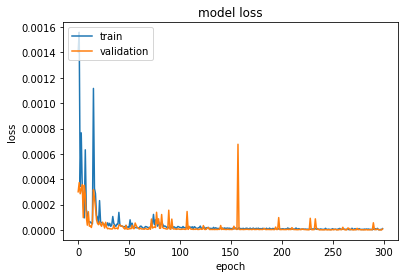

In [16]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluación del Modelo

In [29]:
STEPS_PER_EPOCH = LEN_DT//BATCH_SIZE_TRAIN
loss, mean_sq = model.evaluate(dataset_test 
                               #steps = STEPS_PER_EPOCH//BATCH_SIZE_VAL
                               #workers = THREADS
                              )
K = dict_act_norm['Motor1']["max"] #Ganancia del actuador
print(f'mean_sq: {mean_sq} -> {mean_sq*K} RPM')
print(f'loss: {loss} -> {loss*K} RPM')

    414/Unknown - 156s 378ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - logcosh: 0.0121

ValueError: too many values to unpack (expected 2)

#### Se guarda el Modelo

In [38]:
I = 1
model.save(f'Models/LSTM XYZ_Yaw/LSTM_ControladorPSO_{I}.h5')

In [64]:
I = 1
#model = tf.keras.models.load_model(f'Modelos/ControlLSTM_XYZYaw_{I}.h5')
#model = tf.keras.models.load_model(f'Modelos/LSTM_Test.h5')
#model = tf.keras.models.load_model(f'Modelos/LSTM_{I}.h5')
#model = tf.keras.models.load_model(f'Modelos/LSTM_Test.h5')
model = tf.keras.models.load_model(f'Modelos/ControlLSTMTest_{I}_32In_2048.h5')
print(model.optimizer.lr)
model.summary()

<tf.Variable 'training_2/Adam/learning_rate:0' shape=() dtype=float32, numpy=1e-05>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 128)            82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 64        
Total params: 144,219
Trainable params

In [156]:
array = np.random.randint(10, size=(1, 4, 24))/10
print(np.shape(array))
model.predict(array)

(1, 4, 24)


array([[0., 0., 0., 0.]], dtype=float32)

In [60]:
%%time

x_test = X_test.sample(n=3, random_state=1)
for index, sample in x_test.iterrows():
    print(model.predict([list(sample)])*K['K'])

NameError: name 'X_test' is not defined

In [55]:
%%time
x_test = [0]*len(states_list)
x_test[0] = 1
x_test[1] = -9.8
x_test[2] = 3
print(model.predict([list(x_test)])*K['K'])

ValueError: in user code:

    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 96]


### Guardar los datos de normalizacion de estados en .txt

In [123]:
#Guardar en archivo .txt maximo y minimo de los estados para normalizacion

f_min = open ('min.txt','w')
f_max = open ('max.txt','w')
i=1
for term in states_list_org:
    print(term+" "+str(i))
    print(dict_sts_norm[term]["min"])
    print(dict_sts_norm[term]["max"])
    f_min.write(str(dict_sts_norm[term]["min"]))
    f_min.write("\n")
    f_max.write(str(dict_sts_norm[term]["max"]))
    f_max.write("\n")
    i=i+1
f_min.close()
f_max.close()

X 1
-2.32883215
4.087115765
Y 2
-2.570347309
2.257280588
Z 3
-3.318702459
-0.0076604560019999995
Yaw 4
-5.481692314
5.436785698
Roll 5
-0.7067456245
0.5143908262
Pitch 6
-0.7754461765
1.009016752
Dx 7
-7.666306018999999
6.647099018
Dy 8
-5.2284946439999995
5.789907932
Dz 9
-4.5244045260000005
4.335052013
P 10
-3.630359888
3.692307472
Q 11
-4.033548355
4.239980698
R 12
-6.037271023
6.025427341
X_r 13
-1.9400000569999998
2.0
Y_r 14
-1.8600000140000001
2.257280588
Z_r 15
-2.774622917
0.49000000950000006
Yaw_r 16
-5.4808998110000005
5.436699867000001
Pitch_r 17
0
0
Roll_r 18
0
0
Dx_r 19
-161.86373899999998
170.7974243
Dy_r 20
-100.0
100.3757477
Dz_r 21
-346.043457
380.7929382
Acceleracion X 22
-126.33325959999999
117.5093384
Acceleracion Y 23
-104.098259
74.28073883
Acceleracion Z 24
-86.47660828
63.51453018


### Guardar los datos de desnormalizacion de salidas

In [124]:
f_act = open ('norm_act.txt','w')

for term in rpm_list:
    print(term)
    print(dict_act_norm[term]["min"])
    print(dict_act_norm[term]["max"])
    f_act.write(str(dict_act_norm[term]["min"]))
    f_act.write("\n")
    f_act.write(str(dict_act_norm[term]["max"]))
    f_act.write("\n")
f_act.close()

Motor1
10.0
500.0
Motor2
-500.0
-10.0
Motor3
10.0
500.0
Motor4
-500.0
-10.0


# Test

In [38]:
#Normaliza Test
#print(dict_sts_norm[term]["min"])
#print(dict_sts_norm[term]["max"])
def norm_test(df, dictionary, properties, type_norm="Z-Score"):
    df_norm = pd.DataFrame()    
    for prop in properties:
        #print(f'prop = {prop}')
        #print(f'prop_aux = {prop_aux}')
        #print(f'maximo:{dictionary[prop]["max"]}')
        if type_norm=="Z-Score":
            df_norm[prop] = (df[prop]-dictionary[prop]["mean"])/dictionary[prop]["std"]
        elif type_norm=="Log":
            df_norm[prop] = np.log10(df[prop])
        elif type_norm=="Linear_mean":
            if dictionary[prop]["max"]!=0 or dictionary[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dictionary[prop]["min"])/(dictionary[prop]["max"]-dictionary[prop]["min"]) 
            else:
                df_norm[prop] = df[prop]
        else: #Lineal mean
            if dictionary[prop]["max"]!=0 or dictionary[prop]["min"]!=0:
                df_norm[prop] = (df[prop]-dictionary["mean"])/(dictionary[prop]["max"]-dictionary[prop]["min"])
    return df_norm

In [39]:
print(int(len(states_list)/window))
print(test.columns)

32


NameError: name 'test' is not defined

In [40]:
test.columns

NameError: name 'test' is not defined

In [41]:
ORDER=3
i=0
file_number=20
#delete_list =['Bat_V','Bat_Percentage','Flag_Pitch_Roll','P_r',
#            'Q_r', 'R_r','Acceleracion P', 'Acceleracion Q', 'Acceleracion R']
delete_list =['Bat_V','Bat_Percentage','Flag_Pitch_Roll','P_r',
              'Q_r', 'R_r','Acceleracion P', 'Acceleracion Q', 'Acceleracion R']
rpm_list = ['Motor1','Motor2','Motor3','Motor4']
directory = "./Datasets/DatasetZ_2"
# reading train data
for filename in os.listdir(directory):
    #Si el archivo no termina en .csv continua vuelve al inicio del bucle for
    #if not filename.endswith(".csv"):
    #continue
    i=i+1
    if i!=file_number:
        continue
    a = []
    df = pd.read_csv(os.path.join(directory, filename))
    print(filename)
    Aux = df.drop(rpm_list+delete_list, axis=1)
    origin_columns2 = Aux.drop('Time',axis=1).columns
    origin_columns = Aux.columns
    # desplazar solo las columnas con estados
    for o in range(ORDER):
        delay_columns = origin_columns + '_' + str(o+1)
        a.append(delay_columns)
        Aux[delay_columns]=df.drop(rpm_list+delete_list, axis=1).shift(periods=o+1, fill_value=0)
    # Quitar las 3 primeras filas
    #Aux[rpm_list] = df[rpm_list].drop([0,1,2],axis=0)
    #Aux=Aux.drop([0,1,2],axis=0)
    Aux[rpm_list] = df[rpm_list]
    #print(Aux.columns)
    test = Aux
    break
test[:]  

Oscilacion_Escalonata_Z_4


,Time,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Acceleracion X,Acceleracion Y,Acceleracion Z,Time_1,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Ac_Dx_1,Ac_Dy_1,Ac_Dz_1,Gyro P_1,Gyro Q_1,Gyro R_1,Sonar Altitud_1,Pressure Altitud_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,Time_2,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Ac_Dx_2,Ac_Dy_2,Ac_Dz_2,Gyro P_2,Gyro Q_2,Gyro R_2,Sonar Altitud_2,Pressure Altitud_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,Time_3,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Ac_Dx_3,Ac_Dy_3,Ac_Dz_3,Gyro P_3,Gyro Q_3,Gyro R_3,Sonar Altitud_3,Pressure Altitud_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3,Motor1,Motor2,Motor3,Motor4
0,0.000000,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-1.965233e-06,-0.000002,0.000000,0.000000,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.00000,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.440000,101270.3984,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.00000,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.00000,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.00000,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,342.932495,-342.958404,342.897583,-342.962372
1,0.005000,0.000000e+00,0.000000e+00,-0.046000,-5.307764e-07,2.704250e-06,0.000003,0.000000,0.000000,0.047745,0.000934,0.001025,0.000011,0,0,0.00000,0,0,0,0,0,0.0,0.223515,0.063375,-13.635429,-0.008567,-0.006469,0.002487,0.440000,101270.3984,0.000000,0.000000,9.548991,0.000000,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-1.965233e-06,-0.000002,0.000000,0.000000,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.00000,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.440000,101270.3984,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.00000,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.00000,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,342.898438,-342.940765,342.980499,-342.931152
2,0.010000,7.082289e-10,-6.455718e-10,-0.045761,-7.171090e-08,-4.059651e-06,-0.000005,0.000000,0.000000,0.087995,-0.001353,-0.001527,0.000092,0,0,0.00000,0,0,0,0,0,0.0,-0.117046,-0.251348,-14.080304,-0.010851,-0.009037,-0.000023,0.440000,101270.3984,0.000000,0.000000,8.050011,0.005000,0.000000e+00,0.000000e+00,-0.046000,-5.307764e-07,2.704250e-06,0.000003,0.000000,0.000000,0.047745,0.000934,0.001025,0.000011,0,0,0.00000,0,0,0,0,0,0.0,0.223515,0.063375,-13.635429,-0.008567,-0.006469,0.002487,0.440000,101270.3984,0.000000,0.000000,9.548991,0.000000,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-0.000002,-0.000002,0.000000,0.000000,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.00000,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.440000,101270.3984,0.000000,0.000000

In [42]:
time=test['Time']
out=test[rpm_list]
test=test.drop(rpm_list,axis=1)

for i in range(ORDER+1):
    if i!=0:
        test=test.drop([f'Time_{i}'], axis=1)    
    else:
        test=test.drop(['Time'], axis=1)
test.loc[1:5]

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Ac_Dx_1,Ac_Dy_1,Ac_Dz_1,Gyro P_1,Gyro Q_1,Gyro R_1,Sonar Altitud_1,Pressure Altitud_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Ac_Dx_2,Ac_Dy_2,Ac_Dz_2,Gyro P_2,Gyro Q_2,Gyro R_2,Sonar Altitud_2,Pressure Altitud_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Ac_Dx_3,Ac_Dy_3,Ac_Dz_3,Gyro P_3,Gyro Q_3,Gyro R_3,Sonar Altitud_3,Pressure Altitud_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
1,0.000000e+00,0.000000e+00,-0.046000,-5.307764e-07,2.704250e-06,0.000003,0.0,0.0,0.047745,0.000934,0.001025,0.000011,0,0,0.0,0,0,0,0,0,0.0,0.223515,0.063375,-13.635429,-0.008567,-0.006469,0.002487,0.44,101270.3984,0.0,0.0,9.548991,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-1.965233e-06,-0.000002,0.0,0.0,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.0,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.44,101270.3984,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0000,0.0,0.0,0.000000
2,7.082289e-10,-6.455718e-10,-0.045761,-7.171090e-08,-4.059651e-06,-0.000005,0.0,0.0,0.087995,-0.001353,-0.001527,0.000092,0,0,0.0,0,0,0,0,0,0.0,-0.117046,-0.251348,-14.080304,-0.010851,-0.009037,-0.000023,0.44,101270.3984,0.0,0.0,8.050011,0.000000e+00,0.000000e+00,-0.046000,-5.307764e-07,2.704250e-06,0.000003,0.0,0.0,0.047745,0.000934,0.001025,0.000011,0,0,0.0,0,0,0,0,0,0.0,0.223515,0.063375,-13.635429,-0.008567,-0.006469,0.002487,0.44,101270.3984,0.0,0.0,9.548991,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-1.965233e-06,-0.000002,0.0,0.0,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.0,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.44,101270.3984,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0000,0.0,0.0,0.000000
3,-1.346105e-09,1.140574e-09,-0.045321,-1.382231e-06,9.645310e-07,0.000001,0.0,0.0,0.108800,0.001005,0.001162,-0.000262,0,0,0.0,0,0,0,0,0,0.0,0.252362,0.090067,-13.597730,-0.008497,-0.006330,0.002707,0.44,101270.3984,0.0,0.0,4.160927,7.082289e-10,-6.455718e-10,-0.045761,-7.171090e-08,-4.059651e-06,-0.000005,0.0,0.0,0.087995,-0.001353,-0.001527,0.000092,0,0,0.0,0,0,0,0,0,0.0,-0.117046,-0.251348,-14.080304,-0.010851,-0.009037,-0.000023,0.44,101270.3984,0.0,0.0,8.050011,0.000000e+00,0.000000e+00,-0.046000,-5.307764e-07,2.704250e-06,0.000003,0.0,0.0,0.047745,0.000934,0.001025,0.000011,0,0,0.0,0,0,0,0,0,0.0,0.223515,0.063375,-13.635429,-0.008567,-0.006469,0.002487,0.44,101270.3984,0.0,0.0,9.548991,0.000000e+00,0.000000e+00,-0.046000,-5.859605e-07,-0.000002,-0.000002,0.0,0.0,0.000000,-0.000393,-0.000431,-0.000117,0,0,0.0,0,0,0,0,0,0.0,0.033808,-0.111925,-9.492839,-0.009893,-0.007934,0.001085,0.44,101270.3984,0.0,0.0,0.000000
4,-7.250899e-10,6.158699e-10,-0.044777,5.927828e-07,6.776180e-06,0.000007,0.0,0.0,0.105958,0.001162,0.001192,0.000395,0,0,0.0,0,0,0,0,0,0.0,0.228043,0.067503,-13.629545,-0.008339,-0.006300,0.002521,0.44,101270.3906,0.0,0.0,-0.568339,-1.346105e-09,1.140574e-

In [43]:
origin_columns
window=ORDER+1
test=norm_test(test, dict_sts_norm, test.columns, "Linear_mean")
test.describe()
test.loc[1:5]
test.columns

Index(['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P',
       ...
       'Ac_Dy_3', 'Ac_Dz_3', 'Gyro P_3', 'Gyro Q_3', 'Gyro R_3',
       'Sonar Altitud_3', 'Pressure Altitud_3', 'Acceleracion X_3',
       'Acceleracion Y_3', 'Acceleracion Z_3'],
      dtype='object', length=128)

C:\Users\Eduardo\.conda\envs\Tesis\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


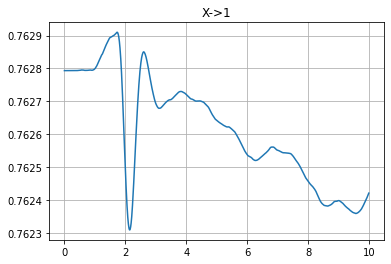

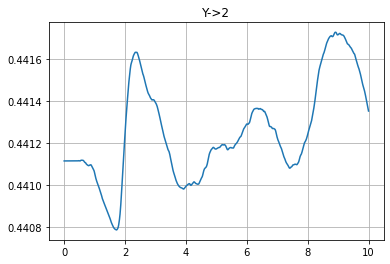

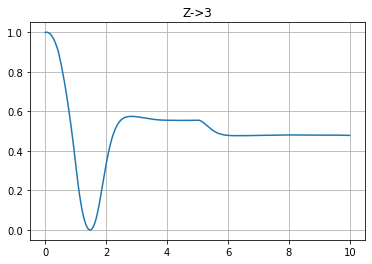

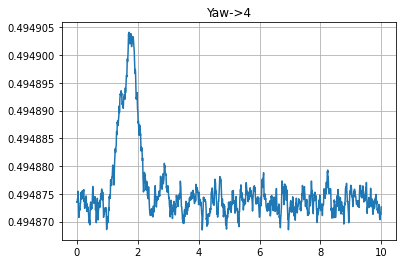

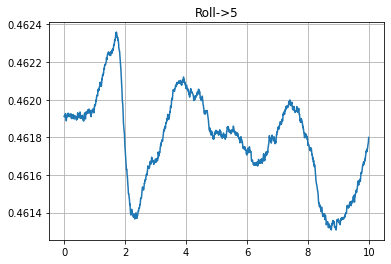

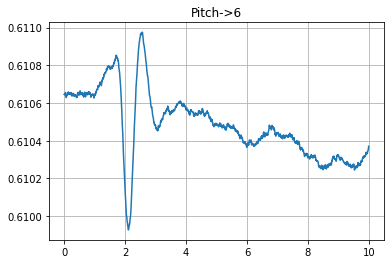

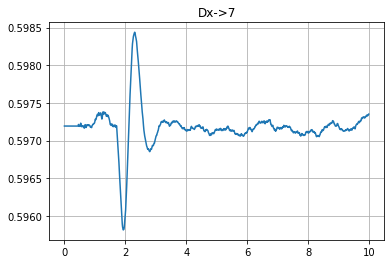

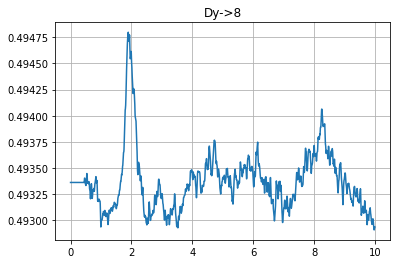

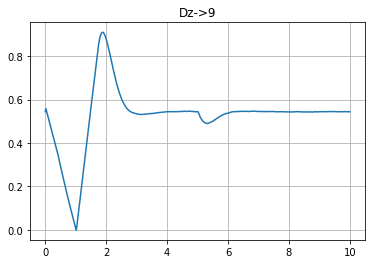

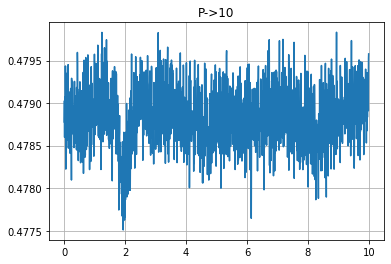

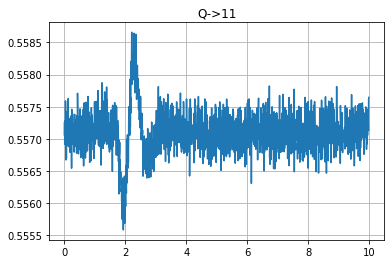

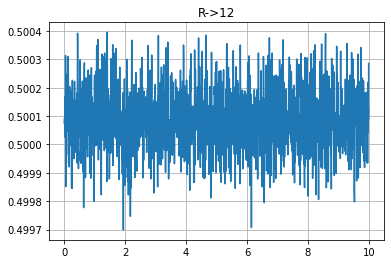

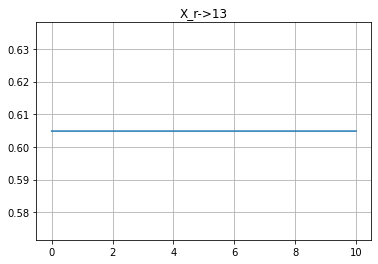

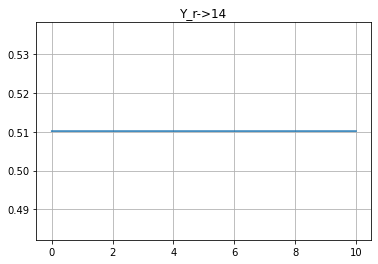

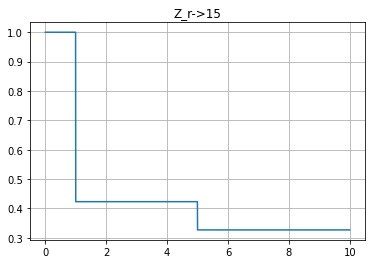

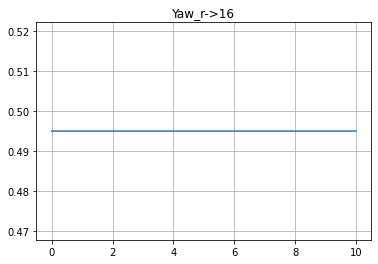

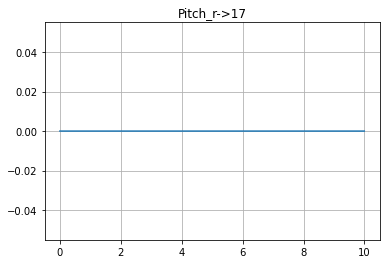

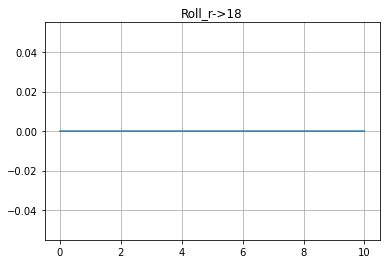

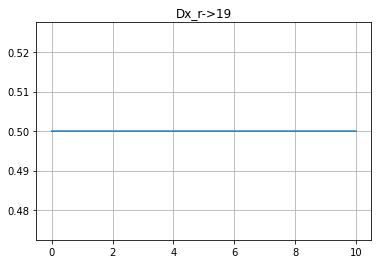

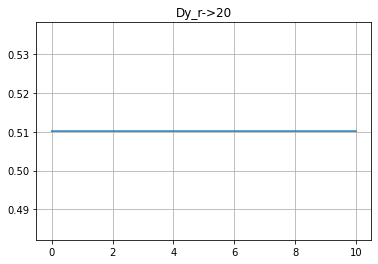

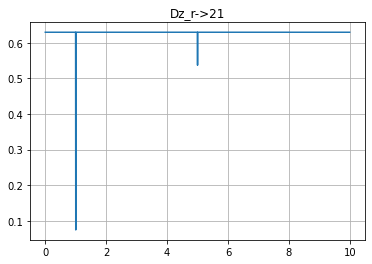

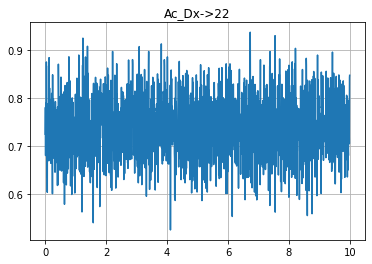

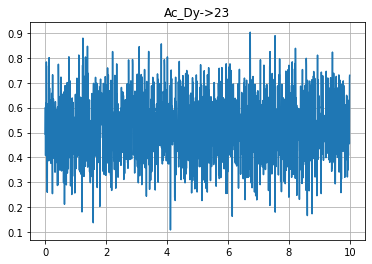

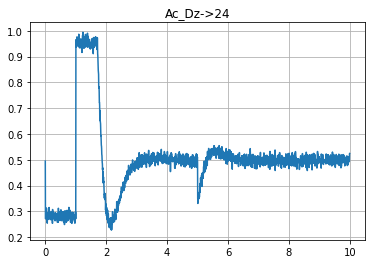

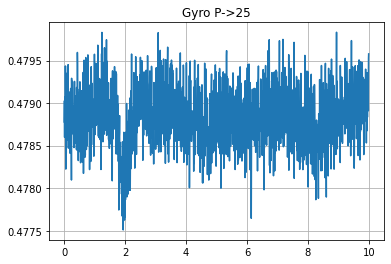

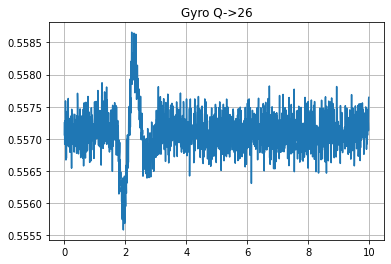

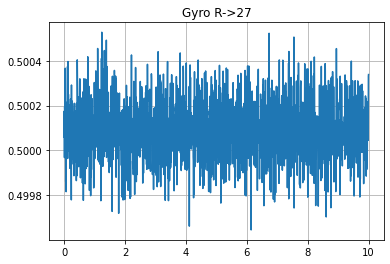

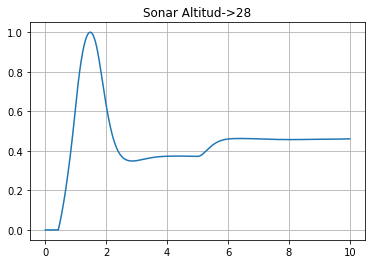

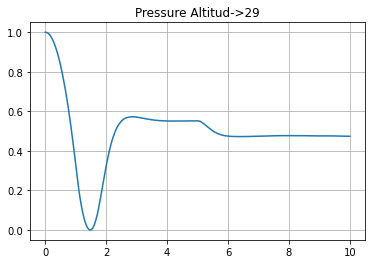

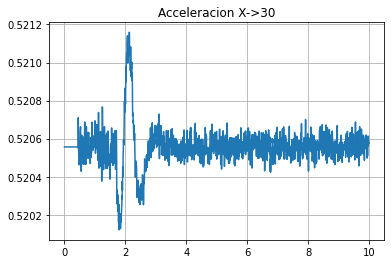

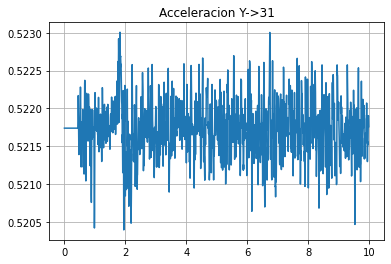

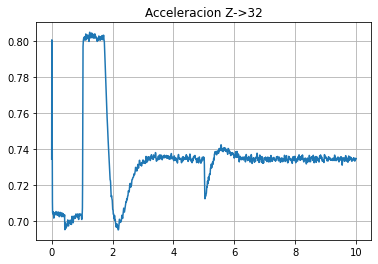

In [44]:
for i,prop in enumerate(origin_columns):
    if prop == 'Time':
        continue
    plt.figure(i)
    plt.plot(time[:2000],test.loc[:1999][prop])
    plt.title(prop + "->" + str(i))
    plt.grid()
#Test=[]
#for i in range(len(test)):
#    Test.append(np.array(test.loc[i]).reshape(4,24))

In [45]:
#print(test.loc[0:4])
"""Input= [[0.3630,    0.3630,    0.3630,    0.3630],
    [0.5324,    0.5324,    0.5324,    0.5324],
    [0.9836,    0.9829,    0.9823,    0.9816],
    [0.5021,    0.5021,    0.5021,    0.5021],
    [0.5788,    0.5787,    0.5787,    0.5787],
    [0.4346,    0.4346,    0.4346,    0.4346],
    [0.5356,    0.5356,    0.5356,    0.5356],
    [0.4745,    0.4745,    0.4745,    0.4745],
    [0.4633,    0.4610,    0.4585,    0.4561],
    [0.4954,    0.4950,    0.4953,    0.4962],
    [0.4877,    0.4874,    0.4874,    0.4875],
    [0.5004,    0.5005,    0.5005,    0.5003],
    [0.4924,    0.4924,    0.4924,    0.4924],
    [0.4518,    0.4518,    0.4518,    0.4518],
    [0.8499,    0.8499,    0.8499,    0.8499],
    [0.5020,    0.5020,    0.5020,    0.5020],
    [     0,         0,         0,         0],
    [     0,         0,         0,         0],
    [0.4866,    0.4866,    0.4866,    0.4866],
    [0.4991,    0.4991,    0.4991,    0.4991],
    [0.4761,    0.4761,    0.4761,    0.4761],
    [0.5341,    0.4499,    0.4556,    0.4833],
    [0.5742,    0.5084,    0.5128,    0.5343],
    [0.3071,    0.2816,    0.2833,    0.2917],
    [0.4954,    0.4950,    0.4953,    0.4962],
    [0.4877,    0.4874,    0.4874,    0.4875],
    [0.5007,    0.5004,    0.5004,    0.5005],
    [0.0000,    0.0000,    0.0000,    0.0000],
    [0.9876,    0.9868,    0.9858,    0.9848],
    [0.5181,    0.5181,    0.5181,    0.5181],
    [0.5836,    0.5836,    0.5836,    0.5836],
    [0.5484,    0.5485,    0.5476,    0.5474]]
Input=np.transpose(Input)

#print(test.loc[1999:2002])
#print(np.shape(Input))
#print(model.predict(np.array(Input).reshape((1,4,32))))
print(model.predict(np.array(test.loc[1999]).reshape((1,4,32))))"""

'Input= [[0.3630,    0.3630,    0.3630,    0.3630],\n    [0.5324,    0.5324,    0.5324,    0.5324],\n    [0.9836,    0.9829,    0.9823,    0.9816],\n    [0.5021,    0.5021,    0.5021,    0.5021],\n    [0.5788,    0.5787,    0.5787,    0.5787],\n    [0.4346,    0.4346,    0.4346,    0.4346],\n    [0.5356,    0.5356,    0.5356,    0.5356],\n    [0.4745,    0.4745,    0.4745,    0.4745],\n    [0.4633,    0.4610,    0.4585,    0.4561],\n    [0.4954,    0.4950,    0.4953,    0.4962],\n    [0.4877,    0.4874,    0.4874,    0.4875],\n    [0.5004,    0.5005,    0.5005,    0.5003],\n    [0.4924,    0.4924,    0.4924,    0.4924],\n    [0.4518,    0.4518,    0.4518,    0.4518],\n    [0.8499,    0.8499,    0.8499,    0.8499],\n    [0.5020,    0.5020,    0.5020,    0.5020],\n    [     0,         0,         0,         0],\n    [     0,         0,         0,         0],\n    [0.4866,    0.4866,    0.4866,    0.4866],\n    [0.4991,    0.4991,    0.4991,    0.4991],\n    [0.4761,    0.4761,    0.4761, 

In [46]:
test.to_csv('example.csv', index=False)

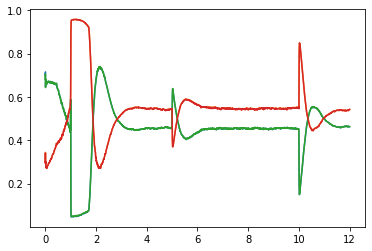

In [47]:
prediction=model.predict(np.array(test.loc[0:2400]).reshape(2401,4,int(len(states_list)/window)))
plt.plot(time[0:2401], prediction[:,:])

In [58]:
#Guardar los datos de la muestra en un archivo .txt
f = open ('Muestra.txt','w')
for column in test.columns:
    f.write(str(test[column].loc[1]))
    f.write("\n")
f.close()

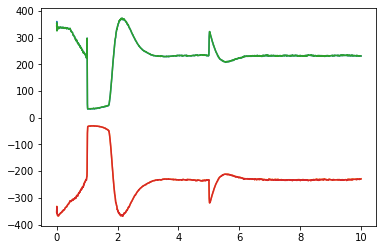

In [49]:

i=0
for rpm in rpm_list:
    prediction[:,i]=prediction[:,i]*(dict_act_norm[rpm]['max']-dict_act_norm[rpm]['min'])+dict_act_norm[rpm]['min']
    i=i+1
    
plt.plot(time[:2000], prediction[:2000,:])


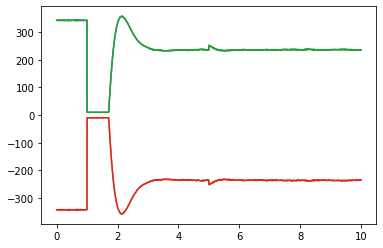

In [41]:
plt.plot(time[:2000], out[:2000])

In [162]:
f = open ('min.txt','r')
mini = f.read()
f.close()
mini=mini.split('\n')
for i,k in enumerate(mini):
    mini[i]=float(mini[i])
    if i==23:
        break
f = open ('max.txt','r')
maxi = f.read()
f.close()
maxi=maxi.split('\n')
for i,k in enumerate(maxi):
    maxi[i]=float(maxi[i])
    if i==23:
        break


In [163]:
mini

[-198.06089780000002,
 -4.819245338,
 -3.318702459,
 -5.481692314,
 -0.8438813686,
 -1.192704678,
 -8.340633392,
 -5.2284946439999995,
 -4.5244045260000005,
 -8.906146049,
 -4.41864872,
 -6.037271023,
 -2.0,
 -2.0,
 -2.774622917,
 -5.4808998110000005,
 0.0,
 0.0,
 -100.00001529999999,
 -100.0,
 -346.043457,
 -126.33325959999999,
 -104.098259,
 -110.9606781,
 '']

In [164]:
def norm_test2(df, properties):
    df_norm = pd.DataFrame()
    for i in range(4):
        for num, prop  in enumerate(properties):
            if i!=0:
                prop=prop+"_"+str(i)
            #print(f'prop = {prop}')
            #print(f'prop_aux = {prop_aux}')
            #print(f'maximo:{dictionary[prop]["max"]}')
            if maxi[num]!=0 or mini[num]!=0:
                df_norm[prop] = (df[prop]-mini[num])/(maxi[num]-mini[num]) 
            else:
                df_norm[prop] = df[prop]
    
    return df_norm

In [168]:
test=norm_test2(test,origin_columns[1:])
test.describe()
test.loc[1:3]

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Acceleracion X,Acceleracion Y,Acceleracion Z,X_1,Y_1,Z_1,Yaw_1,Roll_1,Pitch_1,Dx_1,Dy_1,Dz_1,P_1,Q_1,R_1,X_r_1,Y_r_1,Z_r_1,Yaw_r_1,Pitch_r_1,Roll_r_1,Dx_r_1,Dy_r_1,Dz_r_1,Acceleracion X_1,Acceleracion Y_1,Acceleracion Z_1,X_2,Y_2,Z_2,Yaw_2,Roll_2,Pitch_2,Dx_2,Dy_2,Dz_2,P_2,Q_2,R_2,X_r_2,Y_r_2,Z_r_2,Yaw_r_2,Pitch_r_2,Roll_r_2,Dx_r_2,Dy_r_2,Dz_r_2,Acceleracion X_2,Acceleracion Y_2,Acceleracion Z_2,X_3,Y_3,Z_3,Yaw_3,Roll_3,Pitch_3,Dx_3,Dy_3,Dz_3,P_3,Q_3,R_3,X_r_3,Y_r_3,Z_r_3,Yaw_r_3,Pitch_r_3,Roll_r_3,Dx_r_3,Dy_r_3,Dz_r_3,Acceleracion X_3,Acceleracion Y_3,Acceleracion Z_3
1,0.610681,0.474194,0.988421,0.502056,0.502111,0.494630,0.482986,0.474524,0.511684,0.492360,0.371542,0.500492,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.690698,0.610681,0.474194,0.988421,0.502056,0.502109,0.494628,0.482986,0.474524,0.506341,0.492286,0.371419,0.500481,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968,0.610681,0.474194,1.002314,0.502056,0.502110,0.494629,0.482986,0.474524,0.506341,0.492308,0.371456,0.500491,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968,0.610681,0.474194,1.002314,0.502056,0.502110,0.494629,0.482986,0.474524,0.506341,0.492308,0.371456,0.500491,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968
2,0.610681,0.474194,0.988493,0.502056,0.502108,0.494627,0.482986,0.474524,0.516189,0.492249,0.371327,0.500499,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.682107,0.610681,0.474194,0.988421,0.502056,0.502111,0.494630,0.482986,0.474524,0.511684,0.492360,0.371542,0.500492,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.690698,0.610681,0.474194,0.988421,0.502056,0.502109,0.494628,0.482986,0.474524,0.506341,0.492286,0.371419,0.500481,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968,0.610681,0.474194,1.002314,0.502056,0.502110,0.494629,0.482986,0.474524,0.506341,0.492308,0.371456,0.500491,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968
3,0.610681,0.474194,0.988626,0.502056,0.502110,0.494630,0.482986,0.474524,0.518517,0.492342,0.371553,0.500469,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.659816,0.610681,0.474194,0.988493,0.502056,0.502108,0.494627,0.482986,0.474524,0.516189,0.492249,0.371327,0.500499,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.682107,0.610681,0.474194,0.988421,0.502056,0.502111,0.494630,0.482986,0.474524,0.511684,0.492360,0.371542,0.500492,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.690698,0.610681,0.474194,0.988421,0.502056,0.502109,0.494628,0.482986,0.474524,0.506341,0.492286,0.371419,0.500481,0.501253,0.630915,1.0,0.502024,0,0,0.5,0.5,0.476095,0.500825,0.583579,0.635968


In [35]:
model.optimizer.lr=1e-06

In [32]:
model = tf.keras.models.load_model('tmp')